# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Novas Tecnologias em Banco de Dados</b></center></font>
  
<font size="3"><center>Profa. Dra. SAHUDY MONTENEGRO GONZÁLEZ</center></font>

## <center>Projeto Final</center>

*INTEGRANTES GRUPO 7:*

**Integrante 01**: Laura Rieko Marçal Imai

**RA**: 813451

**Integrante 02**: Pedro Enrico Barchi Nogueira

**RA**: 813099


# Extração e Integração de Dados de Publicações Químicas via Web Scraping

## Sumário
1. [Introdução](#introducao)
2. [Inicialização e Preparação do Ambiente](#inicializacao-e-preparacao-do-ambiente)
3. [Extração dos Dados Básicos (articles.csv)](#extracao-dos-dados-basicos)
4. [Adição da métrica Total Access](#adicao-total-access)
5. [Análise Exploratória](#analise-exploratoria)
6. [Tratamento dos Dados para o Data Warehouse](#tratamento-dados)
7. [Análise dos Dados Tratados](#analise-tratamento)
8. [Processamento de Instituições e Normalização de Localidades](#processamento-localidades)
9. [Análise de Instituições e Localidades](#analise-instituicoes-localidades)
10. [Tratamento de Dados de Instituições e Localização](#tratamento-instituicoes-localidades)
11. [Criação do Banco de Dados e Estrutura das Tabelas](#criacao-banco-de-dados)
12. [Inserção de Dados no Banco de Dados "DW_Projeto"](#insercao-banco-de-dados)
13. [Consultas Realizadas](#consultas-realizadas)
14. [Análises das Consultas](#analise-consultas)
15. [Conclusão](#Conclusao)

## <a id="introducao"></a>Introdução

Neste projeto, desenvolvemos um pipeline de web scraping para extrair e integrar dados de publicações científicas de duas importantes revistas químicas: **Química Nova (QN)** e **Journal of the Brazilian Chemical Society (JBCS)**. O objetivo é coletar informações básicas dos artigos (como título, autores, data de publicação, etc.) e, posteriormente, complementar estes dados com a métrica "Total Access" diretamente dos sites das revistas no portal SBQ. 

### Objetivos do Data Warehouse

O principal objetivo do Data Warehouse é consolidar e estruturar os dados referentes à produção científica em Química no Brasil, permitindo uma análise aprofundada dos seguintes aspectos: a evolução das subáreas da Química ao longo do tempo, a produtividade e distribuição geográfica das instituições e autores, bem como o impacto das publicações medido pelo número de acessos. Ao padronizar e integrar os dados provenientes de diferentes fontes, o DW fornece uma base robusta e confiável para identificar tendências, subáreas emergentes e padrões de colaboração, servindo como ferramenta estratégica para a avaliação e o monitoramento da pesquisa científica no setor.


## <a id="inicializacao-e-preparacao-do-ambiente"></a>Inicialização e Preparação do Ambiente

Nesta seção, preparamos o ambiente de trabalho importando as bibliotecas necessárias e configurando os scripts que compõem o pipeline do projeto. O projeto foi desenvolvido em **Python 3.12.4** e utiliza módulos como `requests` e `BeautifulSoup` para o scraping, além de ferramentas para manipulação e visualização dos dados. A estrutura do projeto está organizada em scripts separados, permitindo que as funções principais (para extração dos dados básicos e para o complemento do 'Total Access') sejam chamadas de forma modular a partir deste notebook.

### Instalando Pacotes Necessários


In [ ]:
# Pacotes para manipulação de dados e web scraping
%pip install requests beautifulsoup4 pandas numpy matplotlib seaborn unidecode rapidfuzz python-dotenv psycopg2 sqlalchemy

### Importações e Configuração Inicial

In [1]:
import csv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
import ast
import psycopg2
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Configuração do logger para acompanhamento do fluxo
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger("ScraperPublicaçõesQuímicas")

# Importação dos scripts do projeto

from scrapers.scraper_basico import run_scraper

from scrapers.scraper_total_access import run_total_access

from scrapers.instituicoes import process_institutions_column, map_state_from_city

from tratamento.tratamento_dados import tratar_dados

from database.estrutura import connect_to_db, create_database, run_sql_script, sql_script

from database.integracao import createTempPubli, insertTempPubli, insertIntoDimensions, insertIntoPontes, insertIntoFato

## <a id="extracao-dos-dados-basicos"></a>Extração dos Dados Básicos (articles.csv)

Nesta etapa, utilizamos o módulo `scraper_basico.py` para extrair as informações fundamentais de publicações das revistas Química Nova (QN) e Journal of the Brazilian Chemical Society (JBCS) a partir da SciELO.  
O resultado deste processo é armazenado em um arquivo CSV intermediário chamado **articles.csv**.  
Esta etapa realiza a extração dos dados básicos, como título, autores, data de publicação, entre outros.

In [ ]:
# Executa o scraper para extrair os artigos
logger.info("Iniciando a extração dos dados básicos (articles.csv)...")
artigos = run_scraper()  # run_scraper() retorna uma lista de dicionários com os dados dos artigos

logger.info(f"Total de artigos extraídos: {len(artigos)}")

# Visualiza os 3 primeiros artigos para verificação
for idx, art in enumerate(artigos[:3], start=1):
    logger.info(f"Artigo {idx}: {art}")

# Salva os dados extraídos no arquivo 'articles.csv'
output_csv_path = "articles.csv"
fieldnames = [
    "journal",
    "year",
    "volume",
    "edition_number",
    "publication_date",
    "publication_type",
    "title",
    "authors",
    "keywords",
    "institutions"
]

logger.info(f"Salvando os dados extraídos em {output_csv_path}...")
with open(output_csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for art in artigos:
        # Caso os campos como authors, keywords, institutions estejam como lista, converta-os em string
        art["authors"] = "; ".join(art["authors"]) if isinstance(art["authors"], list) else art["authors"]
        art["keywords"] = "; ".join(art["keywords"]) if isinstance(art["keywords"], list) else art["keywords"]
        art["institutions"] = "; ".join(art["institutions"]) if isinstance(art["institutions"], list) else art["institutions"]
        if isinstance(art.get("publication_date"), (datetime,)):
            art["publication_date"] = art["publication_date"].strftime("%Y-%m-%d")
        writer.writerow(art)
logger.info(f"Extração concluída! {output_csv_path} foi criado com sucesso.")

## <a id="adicao-total-access"></a>Adição da métrica Total Access

Agora que já extraímos as informações básicas das publicações e armazenamos no arquivo `articles.csv`, iremos complementar esses dados com a métrica **Total Access**.

O **Total Access** representa o número de acessos de cada artigo e será obtido diretamente dos sites das revistas **Química Nova (QN)** e **Journal of the Brazilian Chemical Society (JBCS)**. Para isso, utilizamos o módulo `scraper_total_access.py`, que busca as edições correspondentes de cada periódico e extrai as informações de acesso para cada artigo.

Ao final dessa etapa, um novo arquivo CSV atualizado será gerado: **articles_final.csv**.


In [ ]:
# Define os caminhos dos arquivos de entrada e saída
input_csv = "articles.csv"
output_csv = "articles_final.csv"

print("Iniciando o processo de inclusão do 'Total Access'...")
run_total_access(input_csv, output_csv)
print(f"Processo concluído! Arquivo gerado: {output_csv}")

# Exibir os primeiros registros do CSV final para verificação
import pandas as pd
df_final = pd.read_csv(output_csv)
df_final.head(10)

## <a id="analise-exploratoria"></a>Análise Exploratória dos Dados

Nesta etapa, realizamos uma investigação detalhada do arquivo **articles_final.csv**, que consolida informações integradas das publicações, incluindo a métrica **TotalAccess**. O principal objetivo desta análise é garantir a integridade dos dados e identificar inconsistências, como a presença de valores nulos na métrica de acesso, que possam comprometer as etapas subsequentes de tratamento e modelagem.

Inicialmente, os dados são carregados e a coluna **TotalAccess** é convertida para um formato numérico, em seguida, são exibidas estatísticas descritivas dessa métrica, proporcionando uma visão geral da sua distribuição. Para aprofundar essa análise, foram gerados gráficos que ilustram a distribuição dos acessos, tendo um histograma e um boxplot mostrando os outliers.

Além disso, exploramos a distribuição dos registros em relação aos tipos de revistas e tipos de publicação, utilizando gráficos de contagem para visualizar a frequência de cada categoria. Por fim, a evolução temporal das publicações é analisada agrupando os dados pela coluna **year** e exibindo um gráfico que mostra o número de publicações ao longo dos anos.

Número de registros originais: 12055
Registros com TotalAccess nulo: 2250

Exemplo de registros com TotalAccess nulo:


,journal,year,volume,edition_number,publication_date,publication_type,title,authors,keywords,institutions,TotalAccess
0,QN,2024,47,1.0,2024-01,Artigo,EFFECT OF DIESEL-BIODIESEL-ETHANOL MIXTURES ON...,"Joumaa, Chaza; Saad, Ibtissam; Younes, Ghassan",DBE blend; corrosion; electrochemical impedanc...,"Department of Chemistry, Faculty of Science, B...",NaN
8,QN,2024,47,1.0,2024-01,Educação,A PROPAGAÇÃO DO ERRO DO p K a DA ÁGUA NOS LIVR...,"Antonelli, Leonardo; Paula, Rodrigo De; Cunha,...",NaN,"Instituto de Química, Universidade Federal da ...",NaN
22,QN,2023,46,9.0,2023-10,Artigo,WET TREATMENT AND THE BEHAVIOR OF ELECTROLESS ...,"Flacker, Alexander; Adamo, Cristina B.; Silva ...",alumina; electroless nickel phosphorus; wet su...,Centro de Tecnologia da Informação Renato Arch...,NaN
27,QN,2023,46,9.0,2023-10,Revisão,EFEITO DOS DEFEITOS DE SUPERFICIE E DO pH NA A...,"Farias, Manuel J. S.; Tremiliosi Filho, German...",NaN,"Instituto de Química de São Carlos, Universida...",NaN
37,QN,2023,46,7.0,2023-08,Revisão,TRANSIÇÕES ELETRÔNICAS EM α-Fe 2 O 3 : MODELOS...,"Santos, Isabela F. S.; Faria, Dalva L. A. de",hematite; electronic absorption spectrum; band...,"Departamento de Química Fundamental, Universid...",NaN



Número de registros após remover nulos: 9805

Estatísticas descritivas de TotalAccess:
count     9805.000000
mean      1491.736869
std       2390.541121
min        222.000000
25%        834.000000
50%       1052.000000
75%       1719.000000
max      83679.000000
Name: TotalAccess, dtype: float64


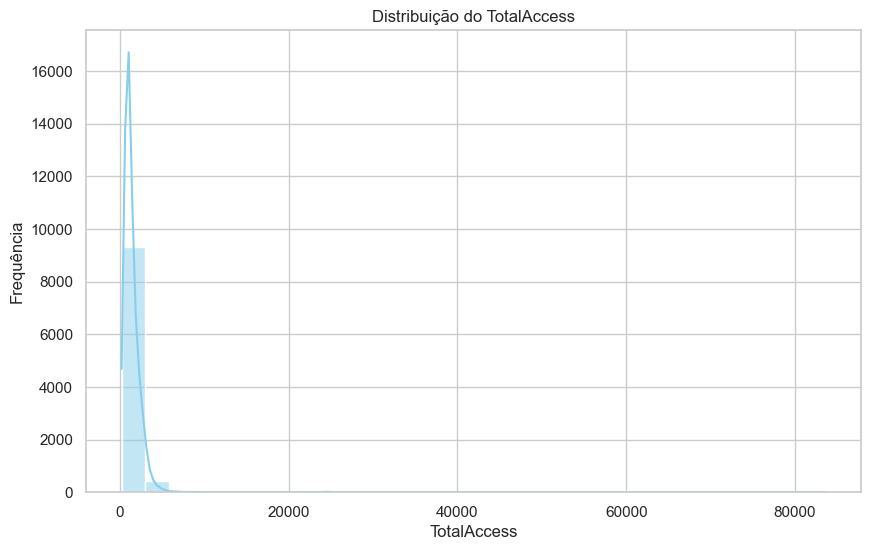

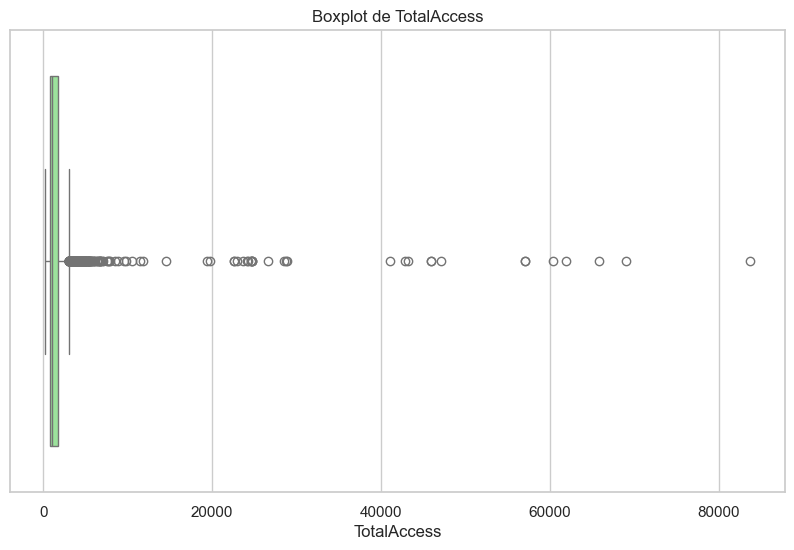

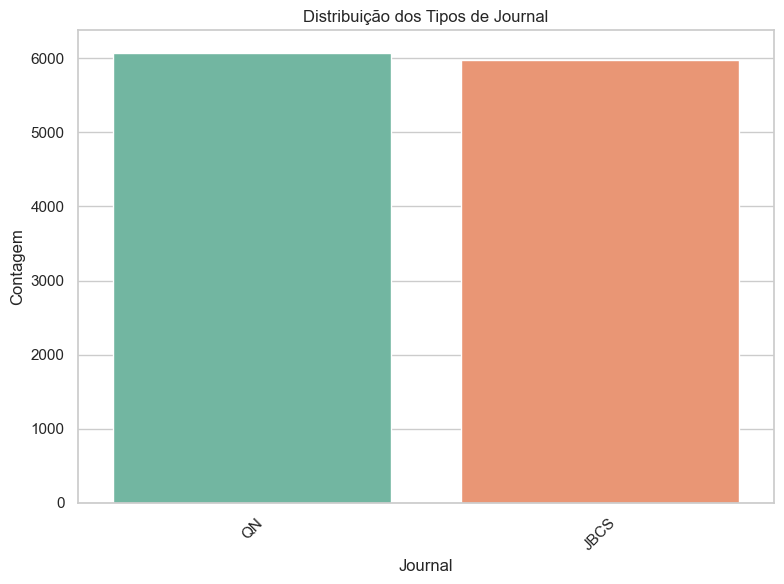

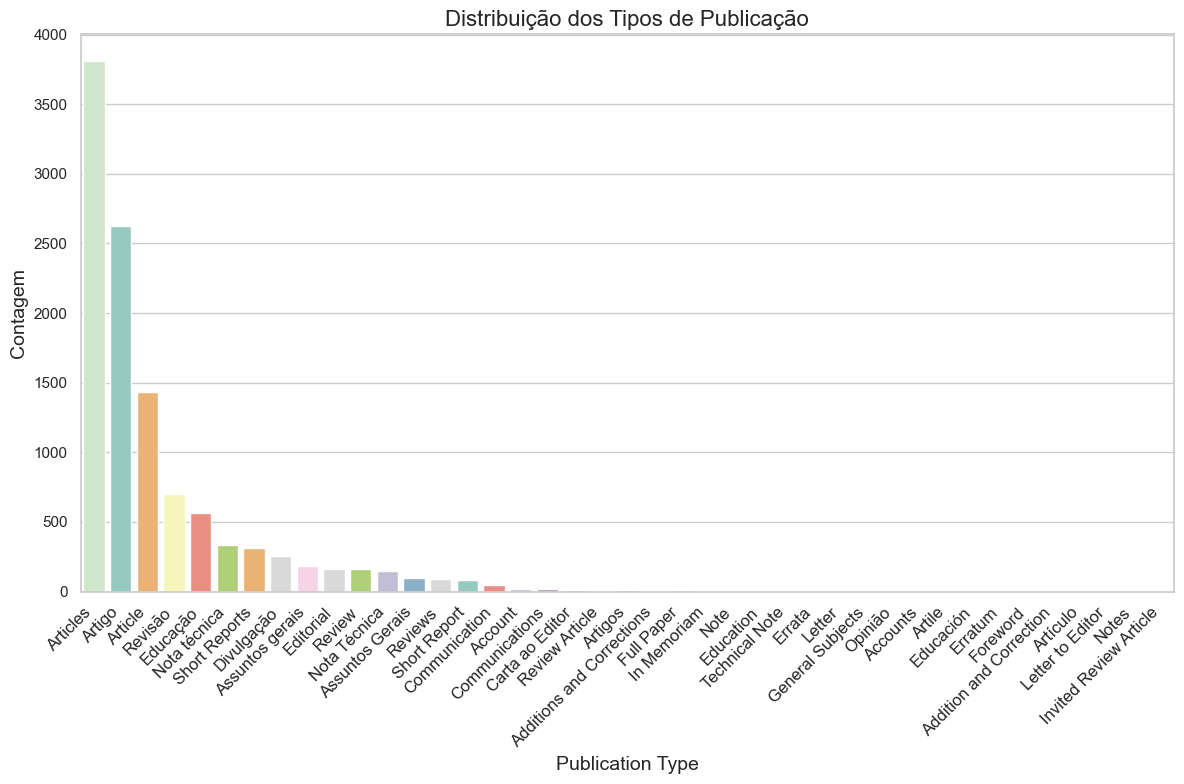

Número de registros com ano definido: 12055


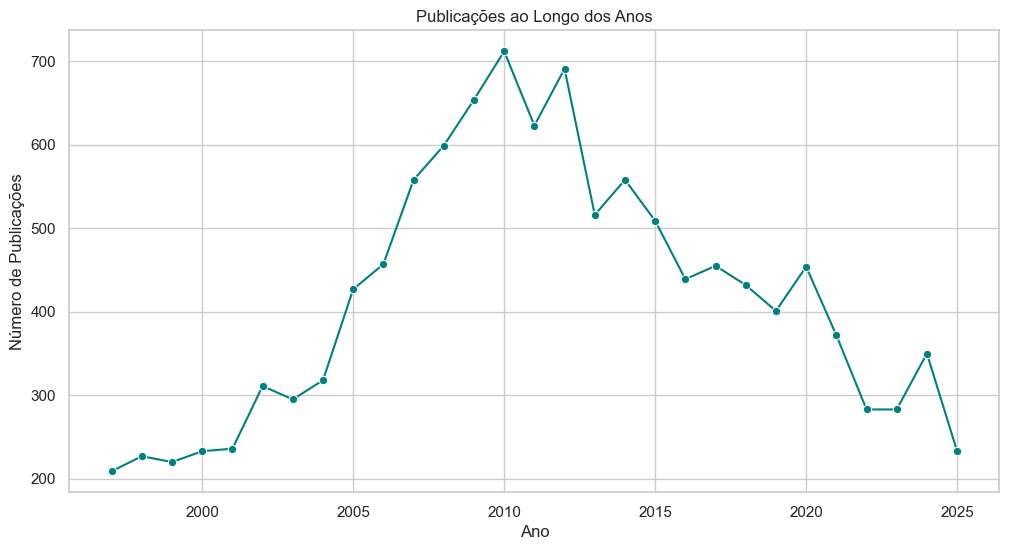

In [10]:
# Configurações para gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Carregar o dataset final
df = pd.read_csv("articles_final.csv")
print("Número de registros originais:", len(df))

# Converter a coluna 'TotalAccess' para numérico; registros não convertíveis serão definidos como NaN
df['TotalAccess'] = pd.to_numeric(df['TotalAccess'], errors='coerce')

# Verificar a quantidade de registros com TotalAccess nulo
missing_total = df['TotalAccess'].isnull().sum()
print("Registros com TotalAccess nulo:", missing_total)

# Exibir uma amostra dos registros com TotalAccess nulo (se houver)
if missing_total > 0:
    print("\nExemplo de registros com TotalAccess nulo:")
    display(df[df['TotalAccess'].isnull()].head())

# Remover registros onde TotalAccess é nulo
df_clean = df.dropna(subset=['TotalAccess'])
print("\nNúmero de registros após remover nulos:", len(df_clean))
df_clean.to_csv("articles_final.csv", index=False, encoding="utf-8")


# Exibir estatísticas descritivas da coluna TotalAccess
print("\nEstatísticas descritivas de TotalAccess:")
print(df_clean['TotalAccess'].describe())

# Histograma da distribuição de TotalAccess com curva KDE
plt.figure()
sns.histplot(df_clean['TotalAccess'], bins=30, kde=True, color='skyblue')
plt.title("Distribuição do TotalAccess")
plt.xlabel("TotalAccess")
plt.ylabel("Frequência")
plt.show()

# Boxplot para identificar possíveis outliers
plt.figure()
sns.boxplot(x=df_clean['TotalAccess'], color='lightgreen')
plt.title("Boxplot de TotalAccess")
plt.xlabel("TotalAccess")
plt.show()

# Gráfico de Distribuição dos Journals
plt.figure(figsize=(8,6))
order_journals = df['journal'].value_counts().index
sns.countplot(data=df, x="journal", hue="journal", order=order_journals, palette="Set2", dodge=False)
plt.title("Distribuição dos Tipos de Journal")
plt.xlabel("Journal")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de Distribuição dos Tipos de Publicação
df_pubtype = df[df["publication_type"].notnull()]
order_pubtype = df_pubtype['publication_type'].value_counts().index
plt.figure(figsize=(12,8))
sns.countplot(data=df_pubtype, x="publication_type", hue="publication_type", order=order_pubtype,palette="Set3", dodge=False)
plt.title("Distribuição dos Tipos de Publicação", fontsize=16)
plt.xlabel("Publication Type", fontsize=14)
plt.ylabel("Contagem", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Converter a coluna year para numérico e remover valores nulos
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df_year = df.dropna(subset=['year'])
df_year['year'] = df_year['year'].astype(int)
print("Número de registros com ano definido:", len(df_year))

# Agrupa as publicações por ano
pubs_by_year = df_year['year'].value_counts().sort_index()

# Gráfico de linha para visualizar as publicações por ano
plt.figure(figsize=(12, 6))
sns.lineplot(x=pubs_by_year.index, y=pubs_by_year.values, marker='o', color='teal')
plt.title("Publicações ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.grid(True)
plt.show()

## <a id="tratamento-dados"></a> Tratamento dos Dados para o Data Warehouse

Nesta etapa, aplicamos operações de limpeza e transformação para padronizar e preparar os dados das publicações para inserí-los no Data Warehouse. As operações incluem:

- Padronização dos nomes das instituições (remoção de acentos, conversão para minúsculas e eliminação de duplicatas);
- Normalização das palavras-chave, convertendo-as para minúsculas e removendo acentos;
- Mapeia as palavras-chave para subáreas da química e adiciona a coluna "subareas";
- Separação e padronização dos nomes dos autores;
- Conversão das datas para um formato consistente (YYYY-MM-DD) e extração dos componentes ano, mês e dia;
- Criação de um identificador único para cada edição, concatenando volume e número;
- Remoção de registros duplicados (mesmo título) entre as revistas.

Após o processamento, os dados serão salvos em um novo arquivo CSV que poderá ser carregado no DW.


In [11]:

# Define os caminhos para o CSV de entrada e saída
input_csv = "articles_final.csv"
output_csv = "articles_tratamento.csv"

# Executa o processo de tratamento
tratar_dados(input_csv, output_csv)

Dados tratados e salvos em articles_tratamento.csv


## <a id="analise-tratamento"></a>Análise dos Dados Tratados

Nesta etapa, exploramos os dados já tratados e processados para identificar características novas. Utilizamos o csv resultante do tratamento para explorar, aspectos das subárias e dos autores. A análise abrange a distribuição do número de subáreas mapeadas por publicação, as subáreas mais recorrentes, a distribuição do número de autores e a relação entre a quantidade de subáreas e a quantidade de autores.


Número de registros tratados: 9799


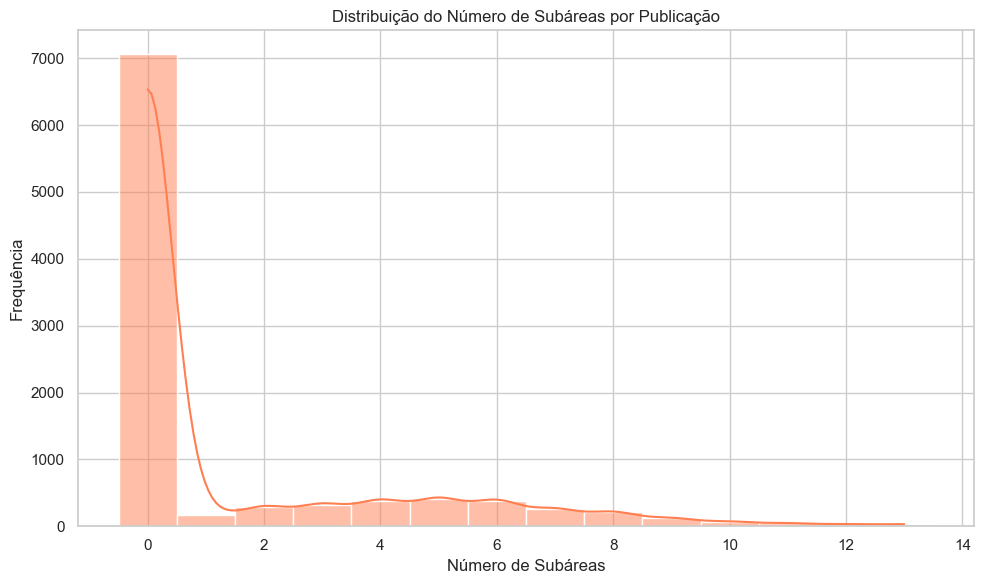

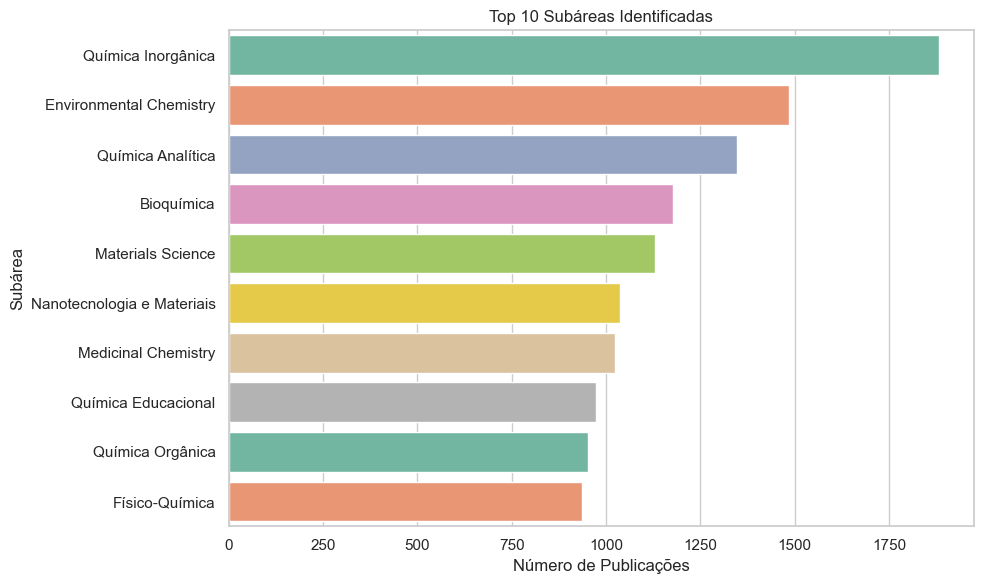

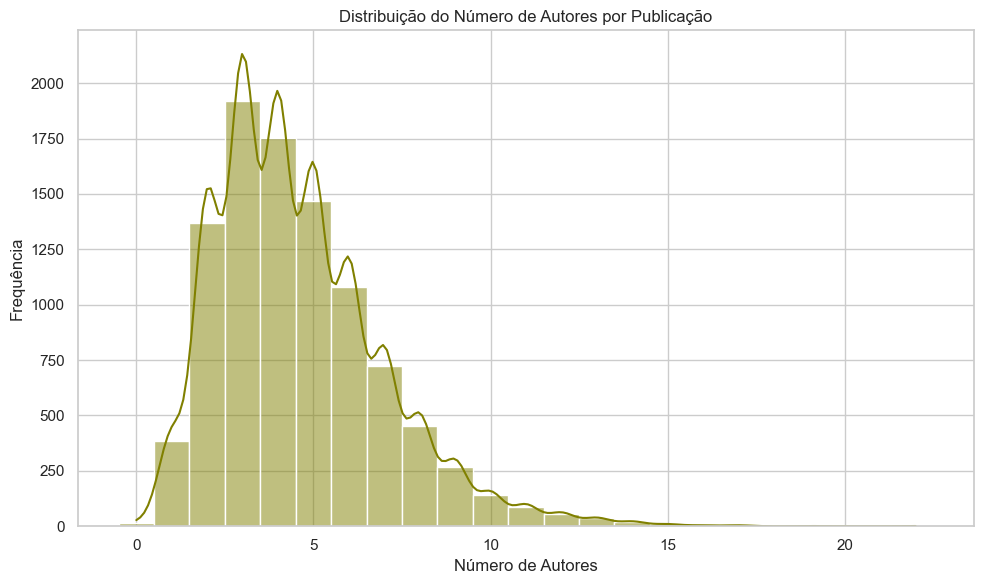

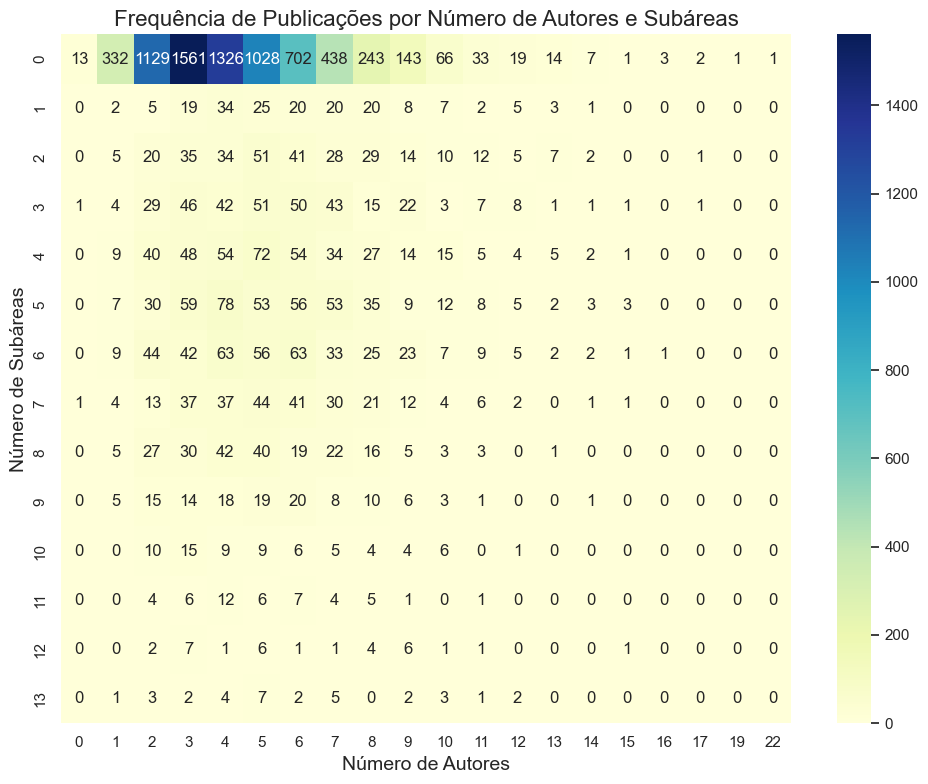


Estatísticas Complementares:
Número de publicações com pelo menos uma subárea: 2737
Número de publicações com pelo menos uma keyword: 2799
Média de subáreas por publicação: 1.4482090009184612
Mediana de subáreas por publicação: 0.0
Média de autores por publicação: 4.586794570874579
Mediana de autores por publicação: 4.0


In [12]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Carregar o dataset tratado
df = pd.read_csv("articles_tratamento.csv", encoding="utf-8")
print("Número de registros tratados:", len(df))

# Converter a coluna 'year' para numérico (se necessário)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Conversão das colunas que armazenam listas (string) para listas reais
def to_list(x):
    try:
        return ast.literal_eval(x) if pd.notnull(x) else []
    except Exception:
        return []

# Garantir que as colunas 'subareas' e 'authors' sejam listas
df['subareas'] = df['subareas'].apply(to_list)
df['authors'] = df['authors'].apply(to_list)

# Número de Subáreas por Publicação
df['num_subareas'] = df['subareas'].apply(lambda x: len(x) if isinstance(x, list) else 0)
plt.figure()
sns.histplot(df['num_subareas'], bins=range(0, df['num_subareas'].max()+2), color="coral", discrete=True, kde=True)
plt.title("Distribuição do Número de Subáreas por Publicação")
plt.xlabel("Número de Subáreas")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# Subáreas mais identificadas
subareas_exploded = pd.Series([sub for sublist in df['subareas'] if isinstance(sublist, list) for sub in sublist])
top_subareas = subareas_exploded.value_counts().head(10)

plt.figure()
sns.barplot(x=top_subareas.values, y=top_subareas.index, hue=top_subareas.index, dodge=False, palette="Set2")
plt.title("Top 10 Subáreas Identificadas")
plt.xlabel("Número de Publicações")
plt.ylabel("Subárea")
plt.tight_layout()
plt.show()

# Número de Autores por Publicação
df['num_authors'] = df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)
plt.figure()
sns.histplot(df['num_authors'], bins=range(0, df['num_authors'].max()+2), color="olive", discrete=True, kde=True)
plt.title("Distribuição do Número de Autores por Publicação")
plt.xlabel("Número de Autores")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# Relação entre Subáreas e Quantidade de autores
pivot = df.groupby(['num_authors', 'num_subareas']).size().reset_index(name='count')
pivot_table = pivot.pivot(index='num_subareas', columns='num_authors', values='count').fillna(0)

plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Frequência de Publicações por Número de Autores e Subáreas", fontsize=16)
plt.xlabel("Número de Autores", fontsize=14)
plt.ylabel("Número de Subáreas", fontsize=14)
plt.tight_layout()
plt.show()


# Estatísticas Complementares
print("\nEstatísticas Complementares:")

# Quantidade de publicações com ao menos uma subárea 
num_pub_with_subareas = df[df['num_subareas'] > 0].shape[0]
print("Número de publicações com pelo menos uma subárea:", num_pub_with_subareas)

# Quantidade de publicações com ao menos uma keyword 
def has_keywords(x):
    # Se já for uma lista, apenas verifica se ela possui elementos
    if isinstance(x, list):
        return len(x) > 0
    # Se for uma string, tenta interpretá-la como uma lista
    try:
        lst = ast.literal_eval(x)
        if isinstance(lst, list):
            return len(lst) > 0
    except Exception:
        return False
    return False

num_pub_with_keywords = df[df['keywords'].apply(has_keywords)].shape[0]
print("Número de publicações com pelo menos uma keyword:", num_pub_with_keywords)

print("Média de subáreas por publicação:", df['num_subareas'].mean())
print("Mediana de subáreas por publicação:", df['num_subareas'].median())
print("Média de autores por publicação:", df['num_authors'].mean())
print("Mediana de autores por publicação:", df['num_authors'].median())

## <a id="processamento-localidades"></a> Processamento de Instituições e Normalização de Localidades

Nesta etapa, importamos as funções do arquivo `instituicoes.py` para processar a coluna `"institutions"` do nosso arquivo de publicações (`articles_dw.csv`). O objetivo é extrair, para cada publicação, informações detalhadas sobre as instituições associadas, tais como o nome da instituição (IES), cidade, estado e país, considerando apenas instituições localizadas no Brasil.

Para garantir a integridade e a consistência dos dados de localidade, especialmente o campo de estado, utilizamos um dicionário de municípios gerado a partir de um arquivo oficial de municípios brasileiros (`municipios_brasil.csv`). Esse dicionário mapeia os nomes normalizados dos municípios para as respectivas siglas dos estados.

Após a extração e normalização, os dados processados são incorporados ao DataFrame original e o arquivo final é salvo como **articles_dw.csv**, preparado para a integração com o Data Warehouse.


In [13]:
# Leitura do CSV de publicações
input_csv = "articles_tratamento.csv"
df = pd.read_csv(input_csv, encoding="utf-8")

# Processa a coluna "institutions" para extrair Instituição, Cidade, Estado e Pais
mapped = df["institutions"].apply(process_institutions_column)
mapped_df = pd.DataFrame(list(mapped))
df = pd.concat([df, mapped_df], axis=1)

# Atualiza a coluna "Estado" utilizando exclusivamente o dicionário de municípios (baseado na coluna "Cidade")
df["Estado"] = df["Cidade"].apply(lambda c: map_state_from_city(c))

# Uniformiza a coluna "Pais" para minúsculas
df["Pais"] = df["Pais"].apply(lambda x: x.lower() if x else x)

# Remove a coluna original "institutions" 
df.drop(columns=["institutions"], inplace=True)

# Salva o DataFrame final processado no arquivo de saída articles_dw.csv
output_csv = "articles_dw.csv"
df.to_csv(output_csv, index=False, encoding="utf-8")
print("Processamento concluído. Dados salvos em articles_dw.csv")

Processamento concluído. Dados salvos em articles_dw.csv


## <a id="analise-instituicoes-localidades"></a> Análise das Instituições e Localidade

Nesta seção, exploramos os dados referentes às instituições e à localização das publicações, que foram integrados ao nosso dataset final (*articles_dw.csv*) após o tratamento anterior. O objetivo é avaliar a completude e a qualidade desses dados, verificando a quantidade de publicações que possuem valores ausentes nas novas colunas – **Instituicao**, **Cidade**, **Estado** e **Pais** – e também identificar quais instituições e estados aparecem com maior frequência. 

Número de registros finais: 9799
Número de publicações sem valor para Instituicao: 3053
Número de publicações sem valor para Cidade: 3002
Número de publicações sem valor para Estado: 4237
Número de publicações sem valor para Pais: 2996


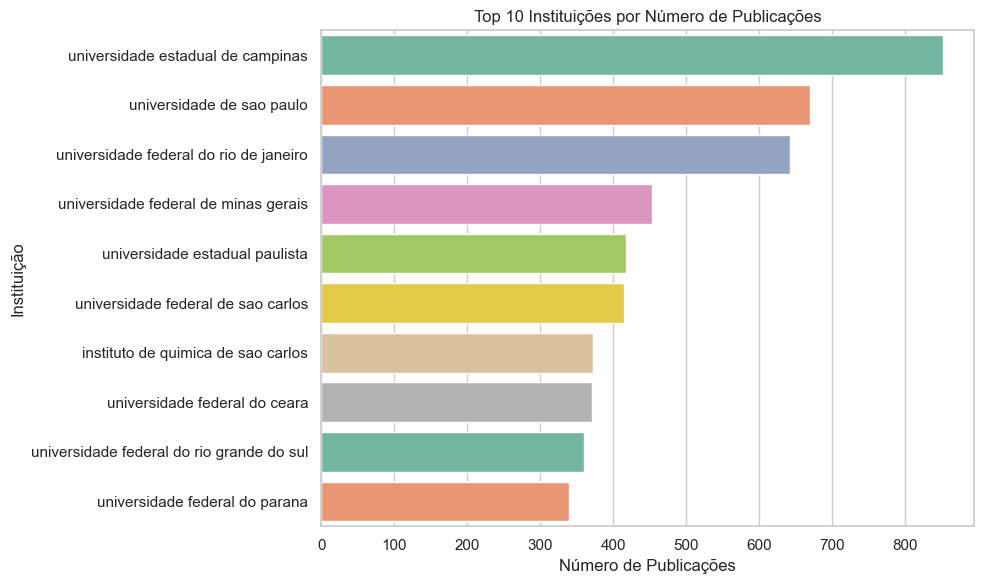

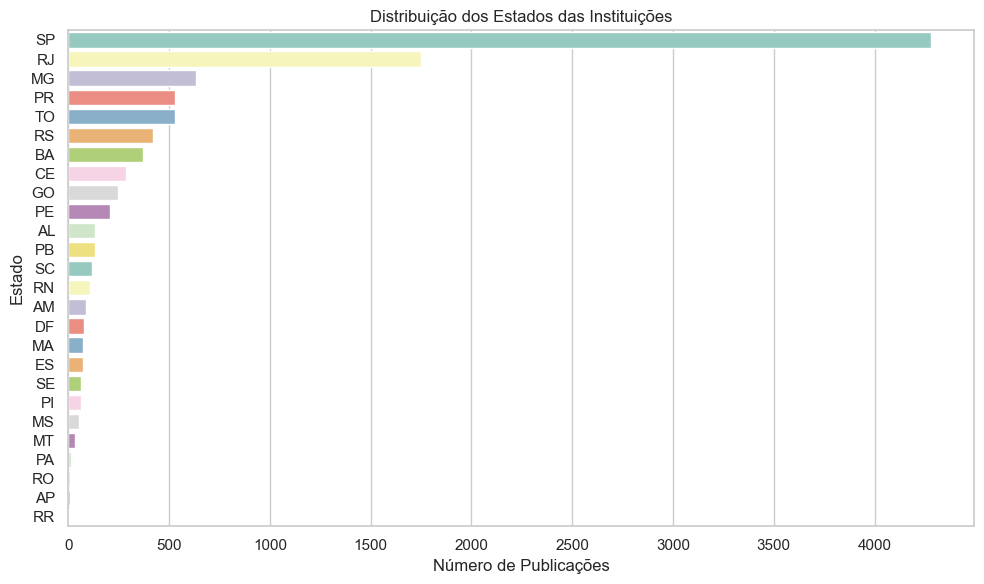

In [14]:
# Configuração dos gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Carregar o dataset final processado com as colunas de "Instituicao", "Cidade", "Estado", "Pais"
df = pd.read_csv("articles_dw.csv", encoding="utf-8")
print("Número de registros finais:", len(df))

# Verificar a quantidade de publicações com valores ausentes nas colunas "Instituicao", "Cidade", "Estado", "Pais"
cols = ["Instituicao", "Cidade", "Estado", "Pais"]
for col in cols:
    missing = df[col].isnull().sum() + (df[col].apply(lambda x: True if isinstance(x, str) and x.strip() == "" else False).sum())
    print(f"Número de publicações sem valor para {col}: {missing}")

# Análise da frequência das Instituições
instituicoes_series = df["Instituicao"].dropna().apply(lambda x: [inst.strip() for inst in x.split(";") if inst.strip()])
instituicoes_exploded = pd.Series([inst for sublist in instituicoes_series for inst in sublist])
top_instituicoes = instituicoes_exploded.value_counts().head(10)

plt.figure()
sns.barplot(x=top_instituicoes.values, y=top_instituicoes.index, hue=top_instituicoes.index, dodge=False, legend=False, palette="Set2")
plt.title("Top 10 Instituições por Número de Publicações")
plt.xlabel("Número de Publicações")
plt.ylabel("Instituição")
plt.tight_layout()
plt.show()

# Distribuição dos Estados das Instituições
estado_series = df["Estado"].dropna().apply(lambda x: [e.strip() for e in x.split(";") if e.strip()])
estados_exploded = pd.Series([estado for sublist in estado_series for estado in sublist])
estado_counts = estados_exploded.value_counts()

plt.figure()
sns.barplot(x=estado_counts.values, y=estado_counts.index, hue=estado_counts.index, dodge=False, legend=False, palette="Set3")
plt.title("Distribuição dos Estados das Instituições")
plt.xlabel("Número de Publicações")
plt.ylabel("Estado")
plt.tight_layout()
plt.show()

## <a id="tratamento-instituicoes-localidades"></a> Tratamento de Dados de Instituições e Localização
Nesta etapa, visamos garantir a integridade dos dados nas colunas "Instituicao", "Cidade", "Estado" e "Pais", que podem conter múltiplos valores e de forma inconsistente entre as colunas.

Filtramos o DataFrame, mantendo apenas as linhas onde o número de elementos é igual entre as quatro colunas, garantindo que as informações estejam consistentes. Para as entradas com valores ausentes, substituímos os nulos por "sem valor", evitando a remoção de registros válidos.

Por fim, removemos as colunas auxiliares de contagem e salvamos o DataFrame final em no próprio arquivo CSV, articles_dw.csv, contendo apenas as publicações com dados completos e consistentes.

In [6]:
# Carregar o dataset
df = pd.read_csv("articles_dw.csv", encoding="utf-8")

# Função para contar o número de elementos não nulos ou vazios nas colunas
def count_elements(col):
    return col.apply(lambda x: len(x.split(";")) if isinstance(x, str) and x.strip() else 0)

# Contagem de elementos nas colunas de interesse
df['Instituicao_count'] = count_elements(df['Instituicao'])
df['Cidade_count'] = count_elements(df['Cidade'])
df['Estado_count'] = count_elements(df['Estado'])
df['Pais_count'] = count_elements(df['Pais'])

# Filtrar as linhas onde o número de elementos é igual nas quatro colunas
df_cleaned = df[(df['Instituicao_count'] == df['Cidade_count']) & 
                (df['Cidade_count'] == df['Estado_count']) & 
                (df['Estado_count'] == df['Pais_count'])].copy()

# Preencher valores nulos com "sem valor"
df_cleaned['Instituicao'] = df_cleaned['Instituicao'].fillna("sem valor")
df_cleaned['Cidade'] = df_cleaned['Cidade'].fillna("sem valor")
df_cleaned['Estado'] = df_cleaned['Estado'].fillna("sem valor")
df_cleaned['Pais'] = df_cleaned['Pais'].fillna("sem valor")

# Remover as colunas auxiliares de contagem
df_cleaned.drop(columns=['Instituicao_count', 'Cidade_count', 'Estado_count', 'Pais_count'], inplace=True)

# Salvar o DataFrame limpo
output_csv = "articles_dw.csv"
df_cleaned.to_csv(output_csv, index=False, encoding="utf-8")
print(f"Dados limpos e salvos em {output_csv}")
print("Número de registros finais:", len(df_cleaned))

Dados limpos e salvos em articles_dw.csv
Número de registros finais: 7498


## <a id="criacao-banco-de-dados"></a> Criação do Banco de Dados e Estrutura das Tabelas
Nesta etapa, vamos garantir que o banco de dados DW_Projeto esteja criado no PostgreSQL. Utilizando uma função de conexão com o banco padrão postgres, verificamos se o banco já existe. Caso contrário, ele é criado de forma automática. 

Com o banco de dados *DW_Projeto* configurado, conectamos diretamente a ele e executamos o script SQL para **criar as tabelas para o nosso Data Warehouse**. O script inclui a criação de tabelas dimensionais, como Dim_Tempo, Dim_TipoPublicacao, Dim_Autor, Dim_Instituicao, e Dim_PalavraChave, além das tabelas ponte (Ponte_Autor, Ponte_Instituicao, Ponte_PalavraChave) e a tabela fato Fato_Publicacao.

In [2]:
# Realizar conexão com banco de dados padrão "postgres"
conn = connect_to_db()

# Criar database "DW_Projeto" caso ele não exista
create_database(conn)

# Conectar ao banco de dados "DW_Projeto" usando as variáveis de ambiente
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST")
)

# Rodar o script sql para criar a estrutura das tabelas do DW
run_sql_script(conn, sql_script)

Banco de dados 'DW_Projeto' já existe.
Estrutura de tabelas criada com sucesso!


## <a id="insercao-banco-de-dados"></a> Inserção de Dados no Banco de Dados "DW_Projeto"
Nesta etapa, conectamos ao banco de dados *DW_Projeto* utilizando variáveis de ambiente para garantir segurança. Em seguida, criamos uma tabela temporária Temp_Publicacoes para carregar os dados do CSV. Após isso, os dados são inseridos nas tabelas dimensionais, como **Dim_Tempo, Dim_TipoPublicacao, Dim_Autor, Dim_Instituicao e Dim_PalavraChave**, utilizando ON CONFLICT DO NOTHING para evitar duplicação.

As tabelas ponte (Ponte_Autor, Ponte_Instituicao, Ponte_PalavraChave) são atualizadas com os dados de vinculação entre publicações, autores, instituições e palavras-chave. A tabela **Fato_Publicacao** é preenchida com informações quantitativas como número de acessos. Por fim, todas as mudanças são salvas com conn.commit(), e a conexão é fechada, garantindo a integridade e consistência do banco de dados.

In [3]:
# Conectar ao banco de dados "DW_Projeto" usando as variáveis de ambiente
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST")
)
cur = conn.cursor()

# Criação de tabela temporária para Publicações
createTempPubli(cur)

data_csv ="articles_dw.csv"
# Inserir dados na tabela temporária Publicações com base no csv de dados
insertTempPubli(cur, data_csv)

# Criação das Dimensões
insertIntoDimensions(cur)

# Criação da Fato
insertIntoFato(cur)

# Criação das Pontes
insertIntoPontes(cur)

# Salvar todas as inserções e fechar a conexão
conn.commit()  
cur.close()
conn.close()

print(f"Inserção de dados de {data_csv} realizada com sucesso!")

Inserção de dados de articles_dw.csv realizada com sucesso!


## <a id="consultas-realizadas"></a> OLAP: Consultas Realizadas

Para essa etapa, executamos as consultas SQL no Data Warehouse para extrair informações relevantes dos dados. A seguir, listamos as consultas realizadas:

- **Consulta 1:** Quais das subáreas da química com maior número de publicações?
- **Consulta 2:** Como se da a evolução das subáreas ao longo do tempo?
- **Consulta 3:** Quais são de subáreas emergentes, comparadas a de anos anteriores?
- **Consulta 4:** Quais são as 10 instituições com maior número de publicações, ordenadas por frequência?
- **Consulta 5:** Como se da a evolução da produção científica das instituições ao longo do tempo?
- **Consulta 6:** Como é a distribuição geográfica das instituições produtivas?
- **Consulta 7:** Qual a evolução da produtividade dos principais autores, identificando os nomes com maior impacto ao longo dos anos?
- **Consulta 8:** Com é distribuição de publicações por mês, agrupadas por quinquenios?
- **Consulta 9:** Qual a evolução total da produtividade científica por ano?
- **Consulta 10:** Existe uma correlação entre o impacto das publicações (número de acessos) e as subáreas da química?


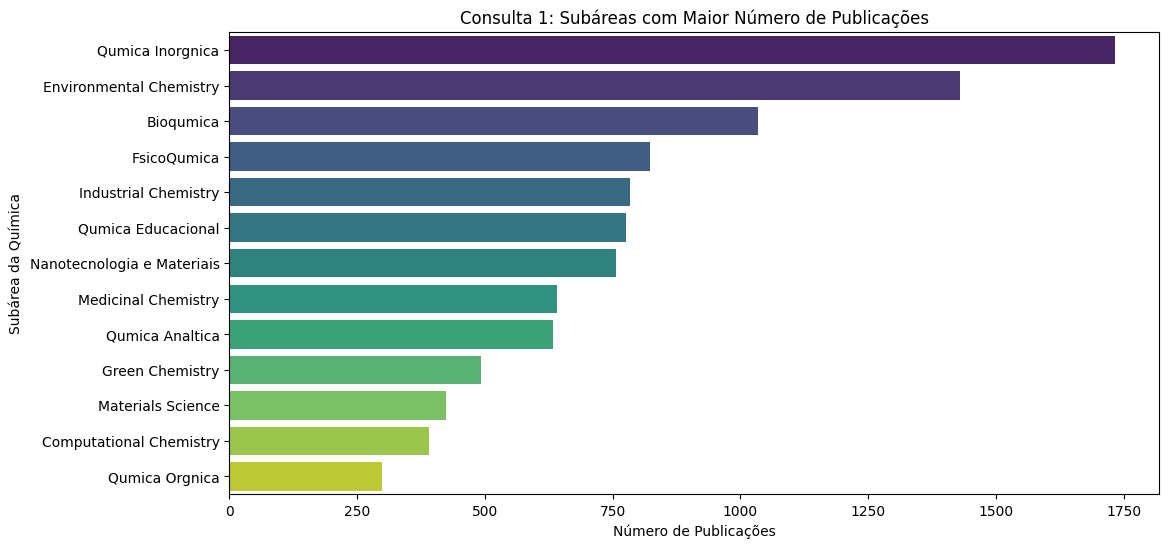

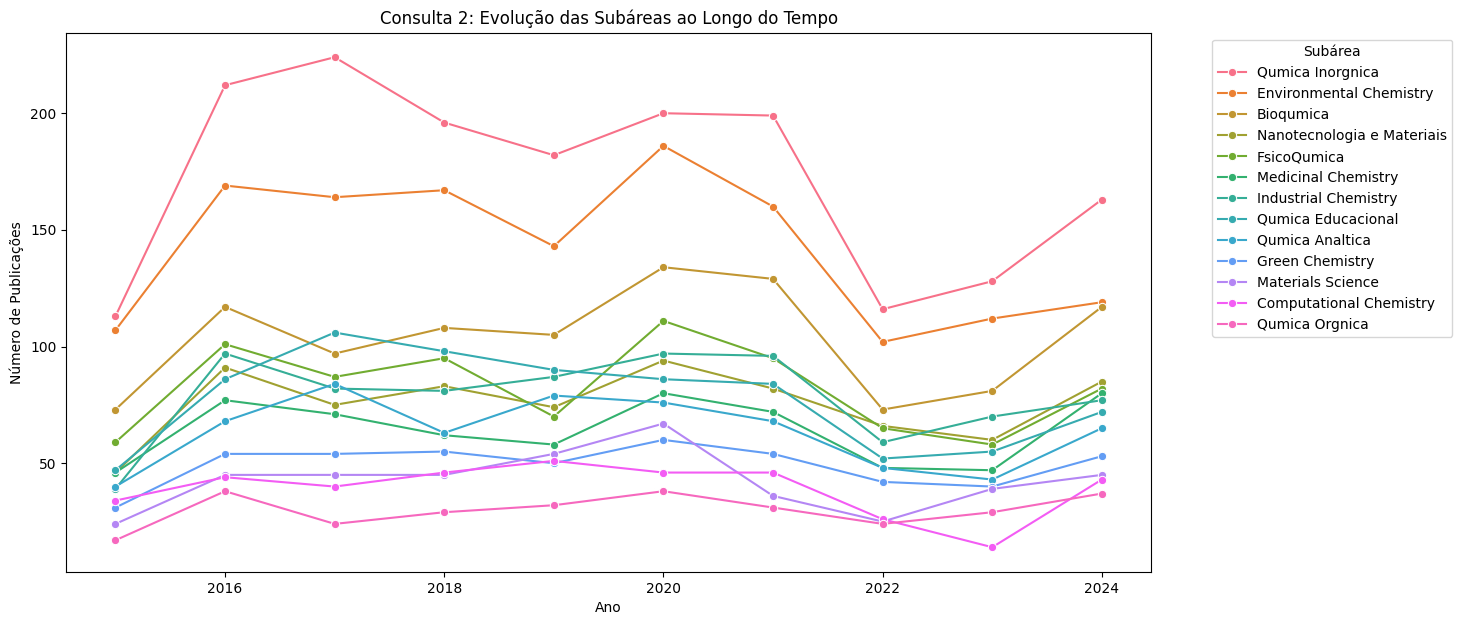

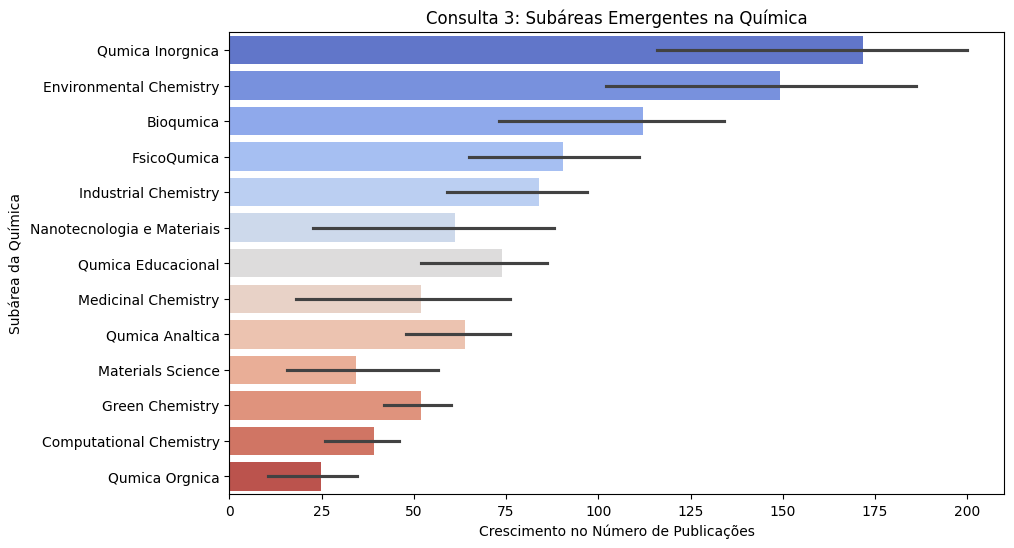

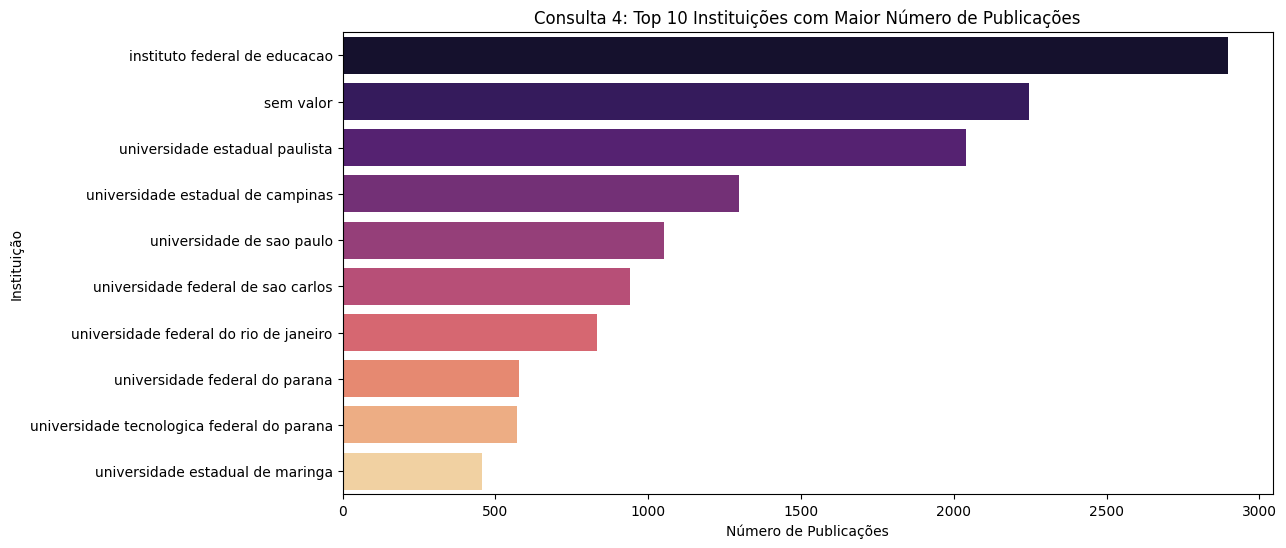

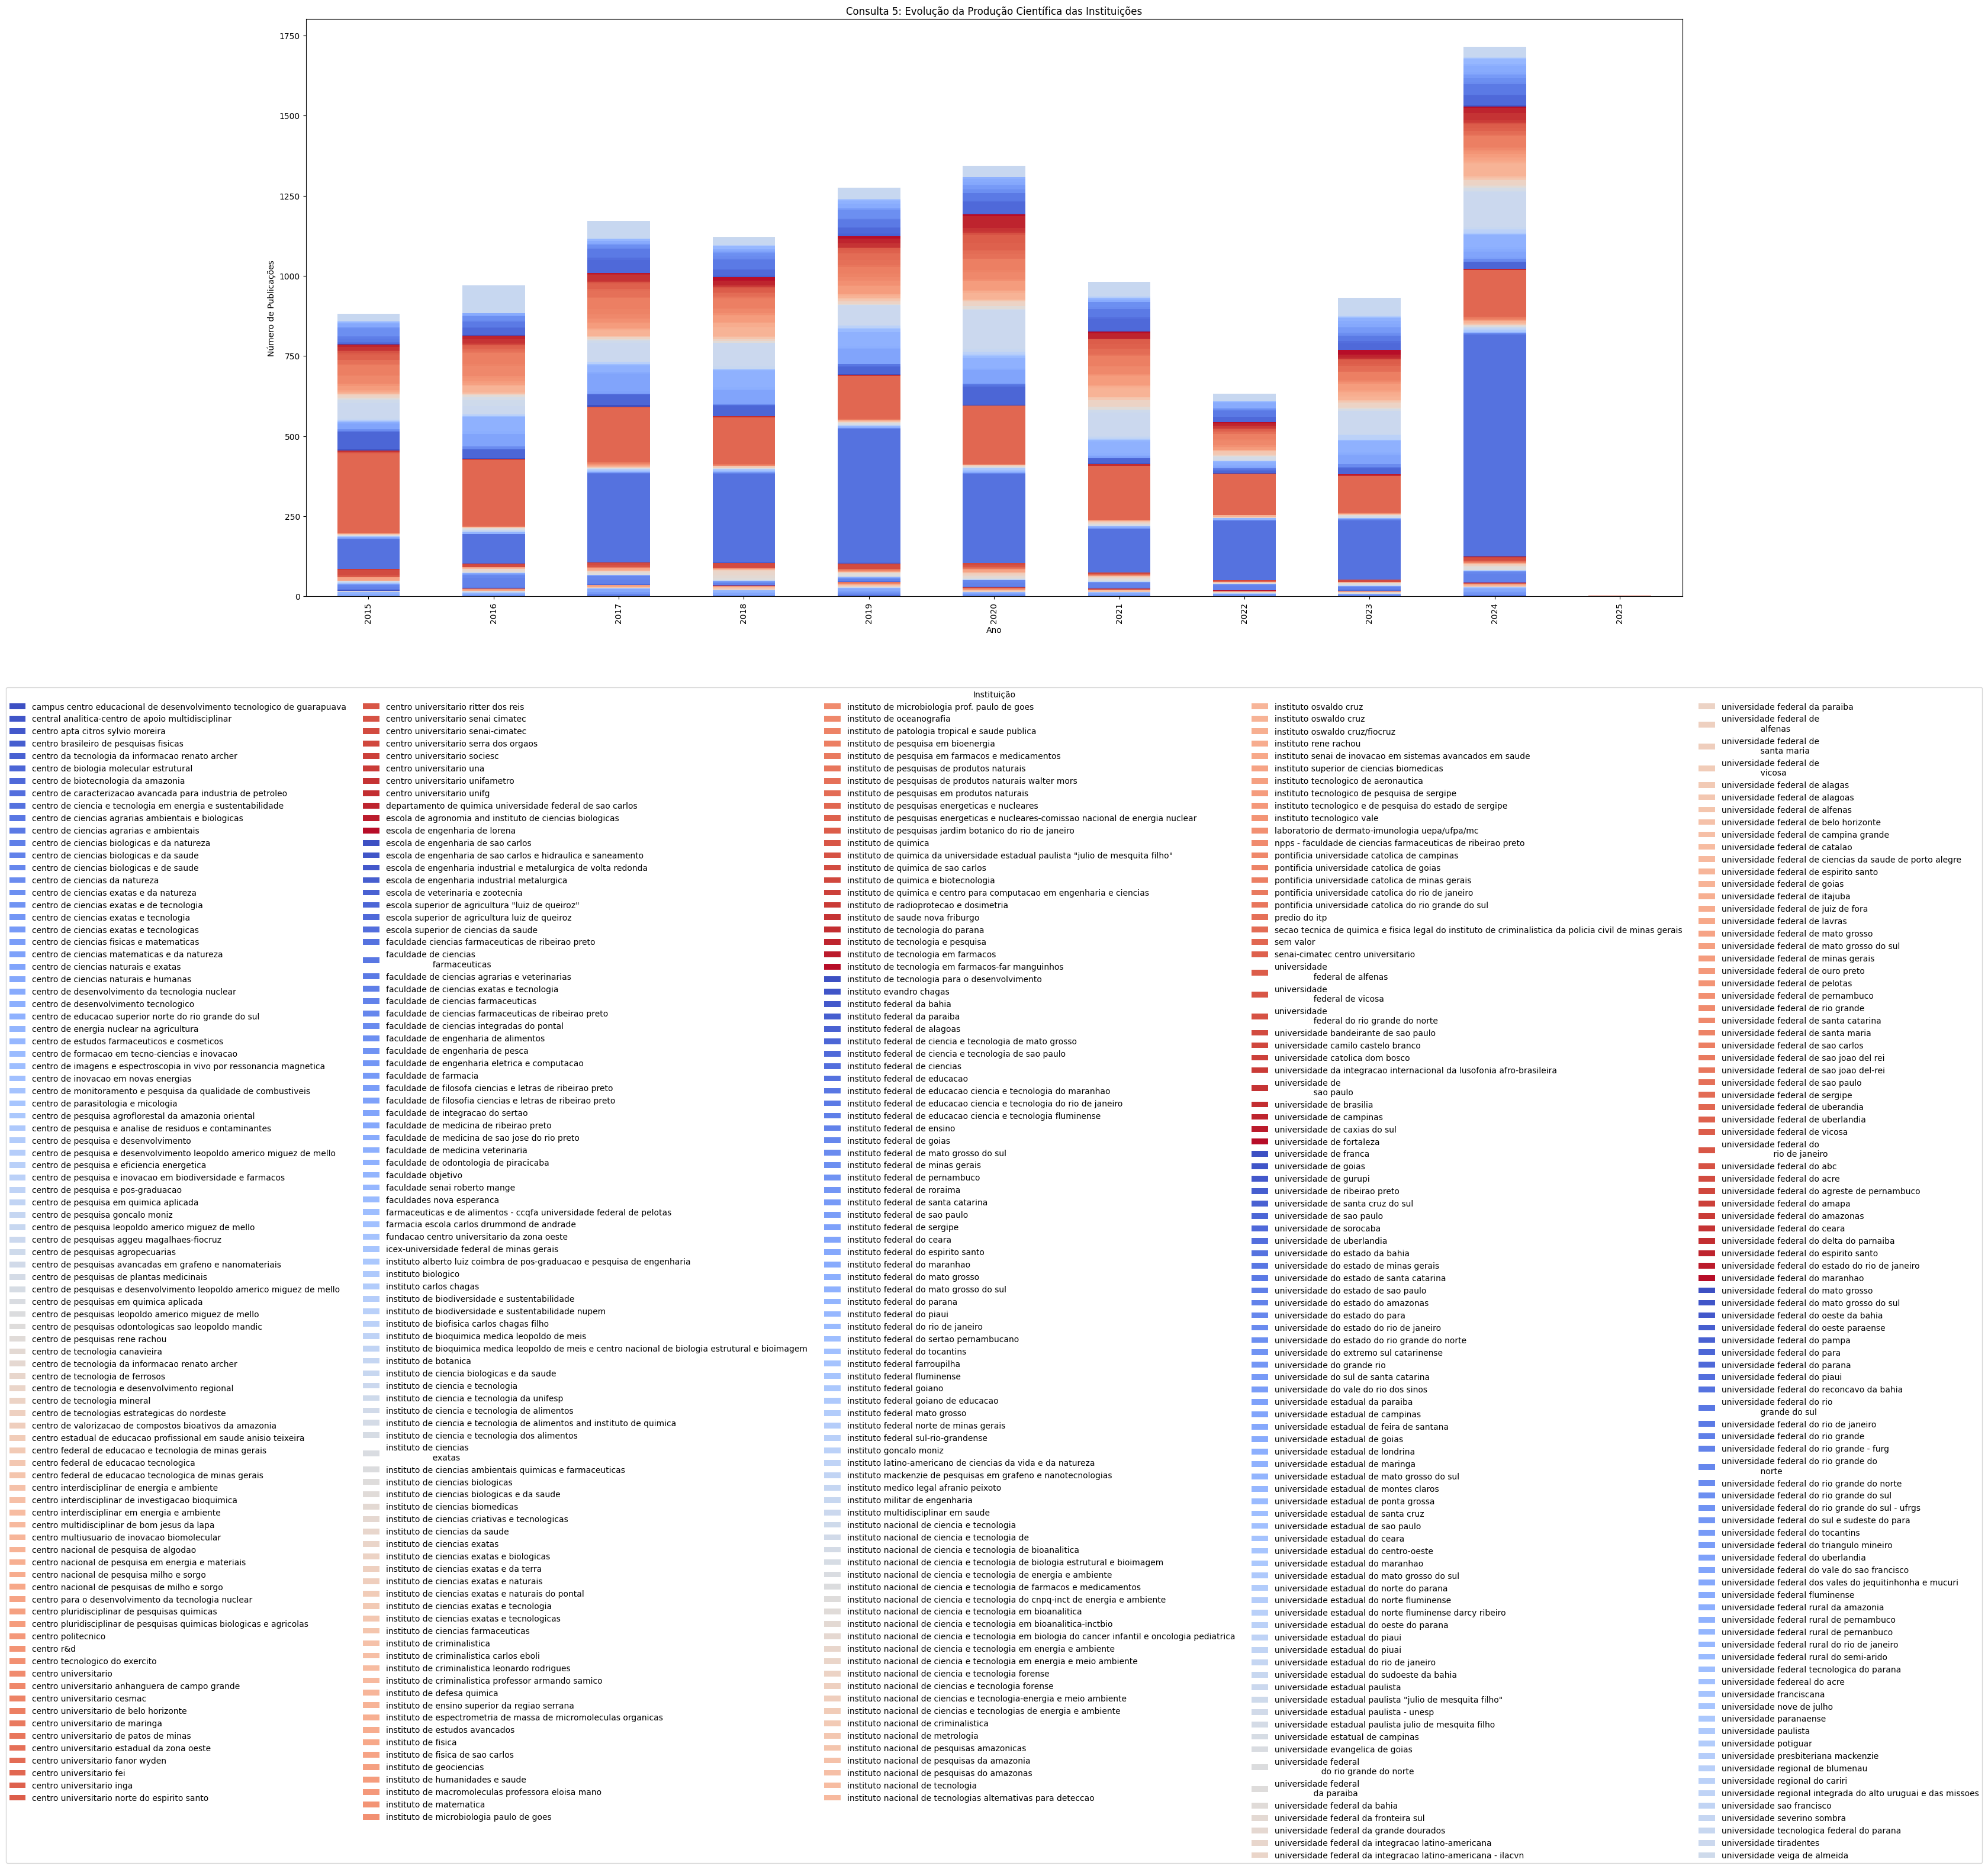

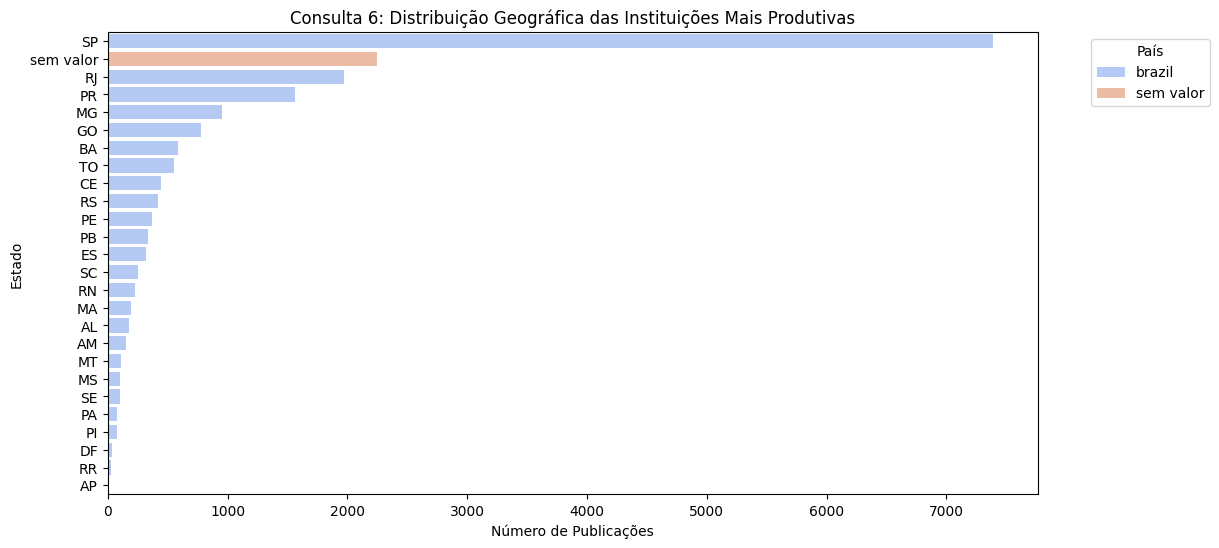

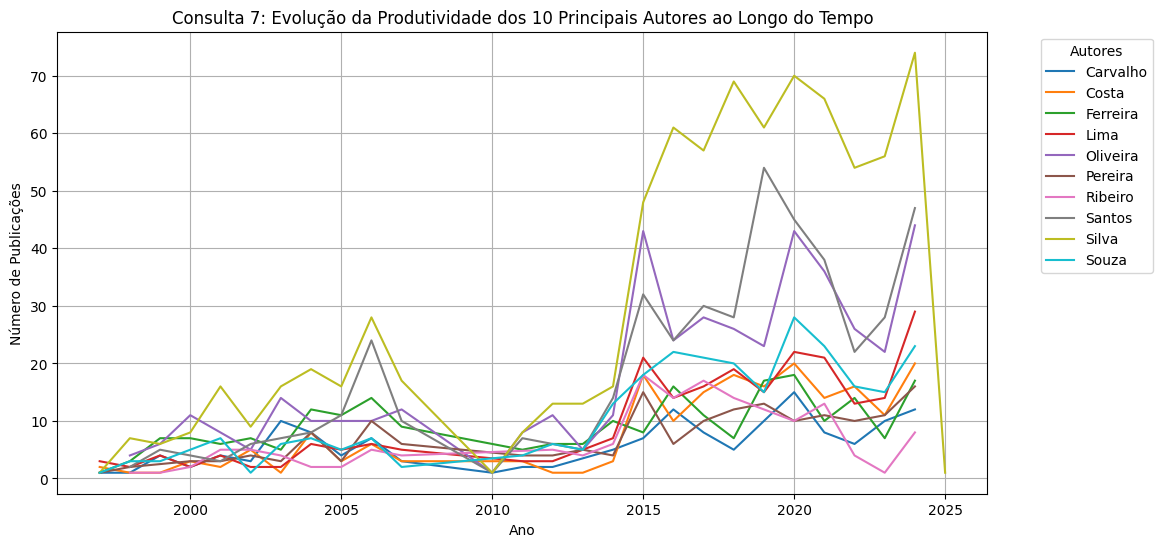

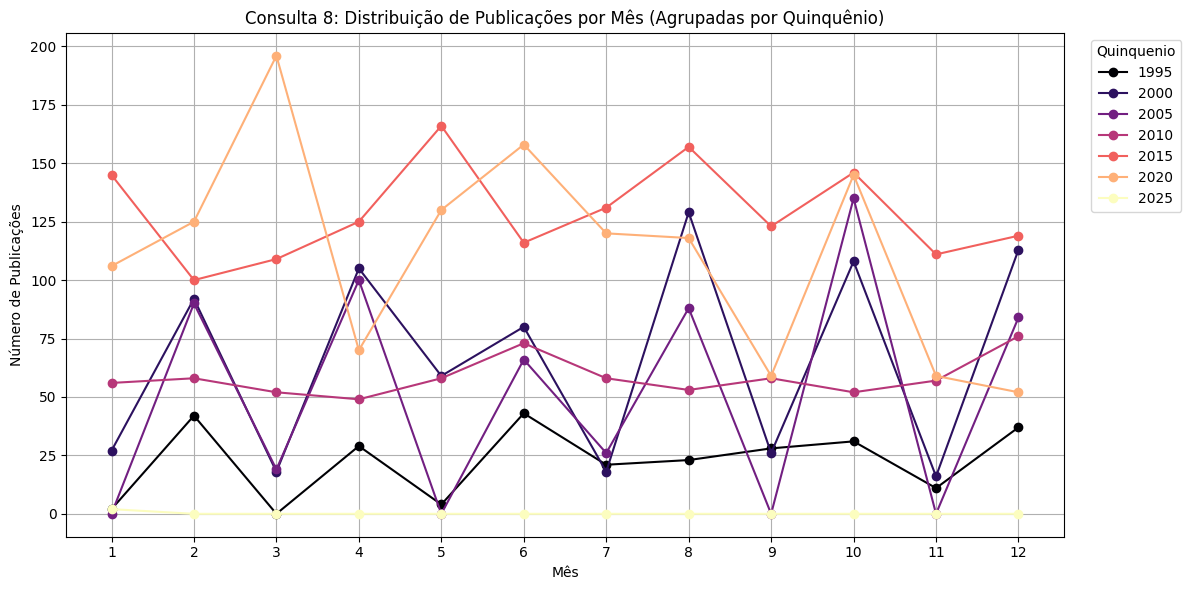

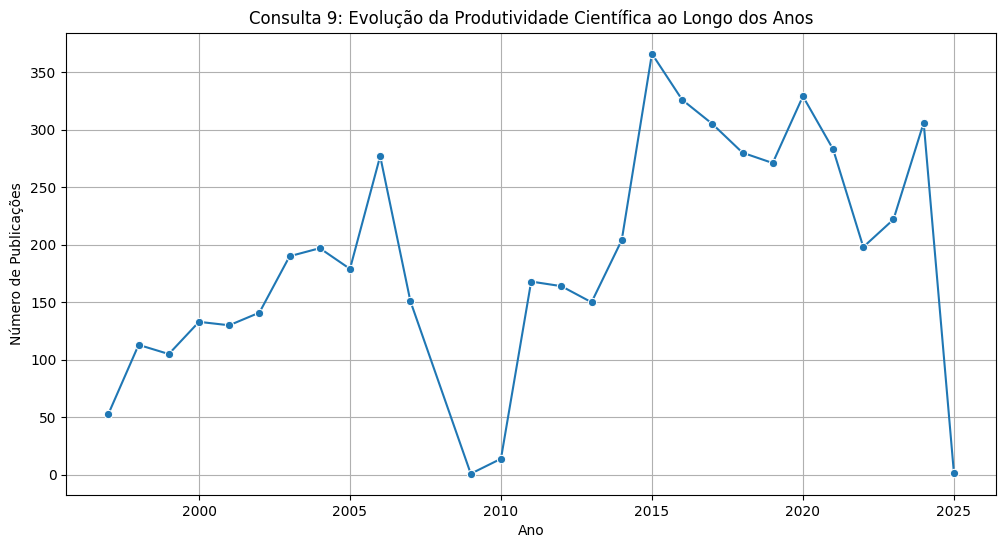

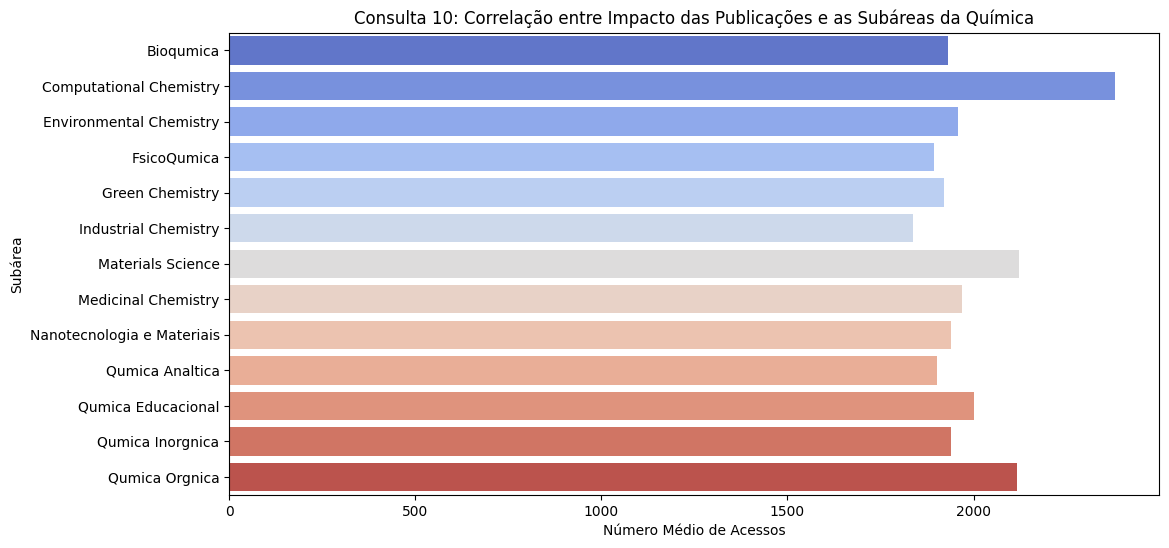

In [4]:

# Criar a string de conexão SQLAlchemy
connection_string = f"postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PASSWORD")}@{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_NAME")}"

# Usando SQLAlchemy para conectar
engine = create_engine(connection_string)

# Função para executar consultas SQL e retornar um DataFrame
def executar_query(query):
    """Executa uma query no banco de dados e retorna um DataFrame."""
    return pd.read_sql(query, engine)
    
# Consulta 1: Quais subáreas da química têm maior número de publicações?
query1 = """
SELECT dp.subarea, COUNT(*) AS total_publicacoes
FROM Ponte_PalavraChave pp
JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
GROUP BY dp.subarea
ORDER BY total_publicacoes DESC;
"""
df1 = executar_query(query1)

plt.figure(figsize=(12,6))
sns.barplot(y=df1['subarea'], x=df1['total_publicacoes'], hue=df1['subarea'],palette='viridis')
plt.xlabel('Número de Publicações')
plt.ylabel('Subárea da Química')
plt.title('Consulta 1: Subáreas com Maior Número de Publicações')
plt.show()

# Consulta 2: Como as subáreas mais populares mudaram nos últimos anos?
query2 = """
SELECT dt.ano, dp.subarea, COUNT(*) AS total_publicacoes
FROM Ponte_PalavraChave pp
JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
JOIN Fato_Publicacao fp ON pp.chavePublicacao = fp.titulo
JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 10
GROUP BY dt.ano, dp.subarea
ORDER BY dt.ano DESC, total_publicacoes DESC;
"""
df2 = executar_query(query2)

plt.figure(figsize=(14,7))
sns.lineplot(data=df2, x='ano', y='total_publicacoes', hue='subarea', marker='o')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.title('Consulta 2: Evolução das Subáreas ao Longo do Tempo')
plt.legend(title='Subárea', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Consulta 3: Quais são as subáreas emergentes
query3 = """
WITH publicacoes_recentes AS (
    SELECT dp.subarea, dt.ano, COUNT(*) AS total_publicacoes
    FROM Ponte_PalavraChave pp
    JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
    JOIN Fato_Publicacao fp ON pp.chavePublicacao = fp.titulo
    JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
    WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 5
    GROUP BY dp.subarea, dt.ano
)
SELECT pr1.subarea, 
       pr1.total_publicacoes AS publicacoes_atuais, 
       COALESCE(pr2.total_publicacoes, 0) AS publicacoes_passadas,
       (pr1.total_publicacoes - COALESCE(pr2.total_publicacoes, 0)) AS crescimento
FROM publicacoes_recentes pr1
LEFT JOIN publicacoes_recentes pr2
    ON pr1.subarea = pr2.subarea AND pr1.ano = pr2.ano + 3
WHERE (pr1.total_publicacoes - COALESCE(pr2.total_publicacoes, 0)) > 0
ORDER BY crescimento DESC;
"""
df3 = executar_query(query3)

plt.figure(figsize=(10,6))
sns.barplot(y=df3['subarea'], x=df3['crescimento'], hue=df3['subarea'], palette='coolwarm')
plt.xlabel('Crescimento no Número de Publicações')
plt.ylabel('Subárea da Química')
plt.title('Consulta 3: Subáreas Emergentes na Química')
plt.show()

# Consulta 4: Quais instituições são responsáveis pelo maior número de publicações?
query4 = """
SELECT di.nome_instituicao, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
GROUP BY di.nome_instituicao
ORDER BY total_publicacoes DESC;
"""
df4 = executar_query(query4)

df4_top10 = df4.head(10)  # Selecionar apenas as 10 primeiras instituições

plt.figure(figsize=(12,6))
sns.barplot(y=df4_top10['nome_instituicao'], x=df4_top10['total_publicacoes'], hue=df4_top10['nome_instituicao'], palette='magma')
plt.xlabel('Número de Publicações')
plt.ylabel('Instituição')
plt.title('Consulta 4: Top 10 Instituições com Maior Número de Publicações')
plt.show()

# Consulta 5: Como a produção científica das instituições evoluiu nos últimos anos?
query5 = """
SELECT dt.ano, di.nome_instituicao, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
JOIN Fato_Publicacao fp ON pi.chavePublicacao = fp.titulo
JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 10
GROUP BY dt.ano, di.nome_instituicao
ORDER BY dt.ano ASC, total_publicacoes DESC;
"""
df5 = executar_query(query5)
df5_pivot = df5.pivot_table(index='ano', columns='nome_instituicao', values='total_publicacoes', aggfunc='sum')

n_colors = 100
colors = sns.color_palette("coolwarm", n_colors)

ax = df5_pivot.plot(kind='bar', stacked=True, figsize=(30,15), color=colors)
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.title('Consulta 5: Evolução da Produção Científica das Instituições')

# Colocar a legenda abaixo do gráfico com
plt.legend(title='Instituição', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)
plt.subplots_adjust(bottom=0.3, top=0.95)
plt.show()

# Consulta 6: Distribuição geográfica das instituições mais produtivas
query6 = """
SELECT di.pais, di.regiao, di.estado, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
GROUP BY di.pais, di.regiao, di.estado
ORDER BY total_publicacoes DESC;
"""
df6 = executar_query(query6)

# Visualização
plt.figure(figsize=(12,6))
sns.barplot(y=df6['estado'], x=df6['total_publicacoes'], hue=df6['pais'], palette='coolwarm')
plt.xlabel('Número de Publicações')
plt.ylabel('Estado')
plt.title('Consulta 6: Distribuição Geográfica das Instituições Mais Produtivas')
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Consulta 7: Como a produtividade dos autores principais mudou ao longo dos anos?
query7 = """
WITH PublicacoesPorAutor AS (
    SELECT 
        a.nome_autor,
        t.ano,
        COUNT(f.titulo) AS numero_publicacoes
    FROM 
        Ponte_Autor pa
    JOIN 
        Dim_Autor a ON pa.chaveAutor = a.chaveAutor
    JOIN 
        Fato_Publicacao f ON pa.chavePublicacao = f.titulo
    JOIN 
        Dim_Tempo t ON f.chaveTempo = t.chaveTempo
    GROUP BY 
        a.nome_autor, t.ano
)
SELECT 
    nome_autor,
    ano,
    numero_publicacoes
FROM 
    PublicacoesPorAutor
WHERE 
    nome_autor IN (
        SELECT nome_autor
        FROM PublicacoesPorAutor
        GROUP BY nome_autor
        ORDER BY SUM(numero_publicacoes) DESC
        LIMIT 10
    )
ORDER BY 
    nome_autor, ano;
"""

# Executar a consulta
df7 = executar_query(query7)

# Visualização
plt.figure(figsize=(12, 6))

# Plotando a evolução da produtividade dos principais autores
for autor in df7['nome_autor'].unique():
    autor_data = df7[df7['nome_autor'] == autor]
    plt.plot(autor_data['ano'], autor_data['numero_publicacoes'], label=autor)

plt.title("Consulta 7: Evolução da Produtividade dos 10 Principais Autores ao Longo do Tempo")
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.legend(title='Autores', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Consulta 8: Identificar meses com maior número de publicações
query8 = """
SELECT 
    dt.quinquenio,
    dt.mes,
    COUNT(f.titulo) AS numero_publicacoes
FROM Fato_Publicacao f
JOIN Dim_Tempo dt ON f.chaveTempo = dt.chaveTempo
GROUP BY dt.quinquenio, dt.mes
ORDER BY dt.quinquenio, dt.mes;
"""

df8 = executar_query(query8)

# Transformar em pivot, com 'mes' como índice e 'quinquenio' como colunas
df8_pivot = df8.pivot(index='mes', columns='quinquenio', values='numero_publicacoes').fillna(0)

df8_pivot.plot(marker='o', figsize=(12, 6), colormap='magma')
plt.title("Consulta 8: Distribuição de Publicações por Mês (Agrupadas por Quinquênio)")
plt.xlabel("Mês")
plt.ylabel("Número de Publicações")
plt.xticks(range(1, 13))  # Meses de 1 a 12
plt.legend(title="Quinquenio", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Consulta 9: Evolução da Produtividade Científica ao Longo dos Anos
query9 = """
SELECT 
    t.ano,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
GROUP BY 
    t.ano
ORDER BY 
    t.ano;
"""

# Executar a consulta
df9 = executar_query(query9)
plt.figure(figsize=(12, 6))

sns.lineplot(data=df9, x='ano', y='numero_publicacoes', marker='o')
plt.title('Consulta 9: Evolução da Produtividade Científica ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.grid(True)
plt.show()

# Consulta 10: Correlação entre Impacto das Publicações e as Subáreas da Química
query10 = """
SELECT 
    dp.palavraChave,
    dp.subarea,
    f.numero_acessos
FROM 
    Fato_Publicacao f
JOIN 
    Ponte_PalavraChave pp ON f.titulo = pp.chavePublicacao
JOIN 
    Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
ORDER BY 
    f.numero_acessos DESC;
"""

# Executar a consulta
df10 = executar_query(query10)
df10_media_subarea = df10.groupby('subarea')['numero_acessos'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(data=df10_media_subarea, x='numero_acessos', y='subarea', hue='subarea', palette='coolwarm')
plt.title('Consulta 10: Correlação entre Impacto das Publicações e as Subáreas da Química')
plt.xlabel('Número Médio de Acessos')
plt.ylabel('Subárea')
plt.show()

## <a id="analise-consultas"></a> Análises Das Consultas
Conclusões sobre a Consulta 1:
Algumas subáreas, como a química inorgânica, dominam em volume de publicações, o que pode indicar que são mais populares, têm mais financiamento, ou são áreas com maior atividade de pesquisa.

Conclusões sobre a Consulta 2:
Essa análise mostra a evolução das tendências em pesquisa química. É possível perceber que após o ano de 2022, as produções em todas as áreas passaram a crescer consistentemente, mas denota-se em específico o crescimento no estudo de duas áreas emergentes: a química orgânica e a química computacional.

Conclusão sobre a Consulta 3: 
Esta análise revela as subáreas que estão crescendo mais rapidamente.Nesse cenário, subáreas com crescimento forte podem indicar novas fronteiras do conhecimento, como química computacional. Além disso, se algumas subáreas tinham poucas publicações no passado e agora estão crescendo rapidamente, pode significar que são áreas promissoras para investimento e pesquisa, ao passo que o crescimento quase nulo, pode indicar áreas estabilizadas ou em declínio.

Conclusão sobre a Consulta 4: 
É passível de conclusão que algumas instituições dominam a produção científica, o que pode indicar sua relevância na pesquisa. Nessa perspectiva, há uma distinção relevante entre as quantidades produzidas pelo primeiro e último lugar exibidos no gráfico, fato este que salienta uma disparidade entre instituições na produção científica. Contudo, é importante ressaltar uma grande quantidade de valores não identificados, que pode ser um fator contribuinte para essa discrepância.

Conclusões sobre a Consulta 5:
Podemos identificar tendências na produção científica das principais instituições. Nesse cenário, destaca-se que a produção total aumentou ao longo dos últimos dois anos, indicando que a pesquisa na área está crescendo de maneira geral, tendo em vista que a pesquisa em química no Brasil em 2022 enfrentou uma redução significativa, possivelmente influenciada principalmente pelas restrições impostas pela pandemia e pela necessidade de adaptação a novas metodologias de ensino e pesquisa.

Conclusões sobre a Consulta 6:
A partir da consulta, pode-se averiguar que a pesquisa científica no país é centrada no estado de São Paulo. À vista disso, o gráfico sugere um cenário pouco equilibrado, onde poucas regiões contribuem para o avanço da ciência, podendo isso ser um reflexo de investimentos governamentais, incentivos à pesquisa ou infraestrutura acadêmica avançada.

Conclusões sobre a Consulta 7:

Conclusões sobre a Consulta 8:
Nesta consulta, é possível analisar a ausência de um teor de sazonalidade nas publicações científicas na área da química. Por outro lado, também é possível perceber que o crescimento geral ao longo dos quinquênios, mostra que o número total de publicações tem aumentado ao longo do tempo.

Conclusões sobre a Consulta 9:
Podemos ver tendências na produção científica ao longo do tempo. Nesse ponto, é importante ressaltar que houveram períodos de queda, pode ser reflexo de crises econômicas, redução de financiamento ou mudanças no cenário científico. Bem como, houveram momentos de vigor nas produções. Desse modo, o gráfico exibe que na área, há momentos de expansão e consolidação, seguidos de um crescimento acelerado e posterior estagnação e queda, para após isso recomeçar o ciclo.

Conclusões sobre a Consulta 10:
Podemos entender quais subáreas atraem mais interesse da comunidade científica. À vista disso, temos como exemplo subáreas como a química computacional um número médio de acessos significativo, isso pode ser atrelado ao crescimento recente e popularidade no momento. Além disso, áreas como a química orgânica não tem tantas produções, mas tem um número alto de acessos, o que pode revelar uma tendência de consumo nichado.


## <a id="conclusao"></a>Conclusão


### Principais Desafios e Aprendizados

Tratamento de dados e qualidade das informações: Um dos maiores desafios encontrados foi o tratamento dos dados coletados. Muitas informações apresentavam inconsistências, registros incompletos e formatos variados, exigindo um trabalho extensivo de limpeza e padronização para garantir a confiabilidade das análises.

Transformação dos dados para a modelagem prevista: Uma das maiores dificuldades encontradas foi transformar os dados brutos extraídos de arquivos CSV para a estrutura de modelagem multidimensional definida previamente. Os dados apresentavam problemas como falta de padronização nas palavras-chave, registros duplicados e inconsistências nos formatos de datas e categorias. 

### Conclusões Finais
A experiência adquirida com este projeto reforçou a importância de estratégias robustas para a coleta, tratamento e padronização de dados em ambientes reais. A dificuldade em lidar com informações não estruturadas mostrou a necessidade de desenvolver soluções flexíveis para garantir análises mais confiáveis e úteis. Apesar dos desafios, a conclusão deste trabalho nos permitiu aprimorar nossas habilidades em modelagem de dados, ETL e análise de informações em larga escala.

### Fluxograma Geral

<img src="figs/Fluxograma.png" alt="Logo UFScar" width="1000" align="left"/>